## Sobhan Asasi
## 400206392


## Requirements

In [1]:
# Import required packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

import torchtext
from torchtext.data import get_tokenizer

### Tokenizer
tokenizer = get_tokenizer("basic_english")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import random
import math
import time



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device is : {device}')

Device is : cuda


In [2]:
SEED = 40

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
path = 'ferdousi.txt'
def file_reader(path):
    with open(path) as file:
        for row in file:
            yield row

def text_to_data(path):
    
    """
    path: str "path of text file"
    
    """
    
    file_gen = file_reader(path)
    poem_dict = {'Input':[],'Output':[]}
    
    for line, text in enumerate(file_gen):
        if line < 2 : continue # Ignore first two lines because these are useless
        if line % 4 == 2:
            b1 = ''
            b1 = text[:-1]
        elif line % 4  == 3:
            b1 = b1 + ' / ' + text[:-1]
            poem_dict['Input'].append(b1)
        elif line % 4 == 0:
            b2 = ''
            b2 = text[:-1]
        else:
            b2 = b2 + ' / ' + text[:-1]
            poem_dict['Output'].append(b2)
        
    return pd.DataFrame(poem_dict)

df = text_to_data(path)
df.head(5)

,Input,Output
0,به نام خداوند جان و خرد / کزین برتر اندیشه برن...,خداوند نام و خداوند جای / خداوند روزی ده رهنمای
1,خداوند کیوان و گردان سپهر / فروزنده ماه و ناهی...,ز نام و نشان و گمان برترست / نگارندهٔ بر شده پ...
2,به بینندگان آفریننده را / نبینی مرنجان دو بینن...,نیابد بدو نیز اندیشه راه / که او برتر از نام و...
3,سخن هر چه زین گوهران بگذرد / نیابد بدو راه جان...,خرد گر سخن برگزیند همی / همان را گزیند که بیند...
4,ستودن نداند کس او را چو هست / میان بندگی را بب...,خرد را و جان را همی سنجد اوی / در اندیشهٔ سخته...


In [4]:
train_df, test_df = train_test_split(df, test_size=0.2)
test_df, val_df = train_test_split(test_df, test_size=0.5)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
train_df.tail(5)

,Input,Output
19838,ورا گردیه هیچ پاسخ نداد / نه از رای آن مهتران ...,چنین گفت اوبا دبیر بزرگ / که ای مرد بدساز چون ...
19839,بگو تاسوی طیسفونش برند / بدان خانهٔ رهنمونش برند,بباشد به آرام ما روز چند / نباید نماید کس او ر...
19840,بران دادگر کو جهان آفرید / پس از آشکارا نهان آ...,دو گیتی پدید آمد از کاف و نون / چرانی به فرمان...
19841,ببر طوق با یاره و گوشوار / یکی تاج پر گوهر شاهوار,صد اشتر ز گستردنیها ببر / صد اشتر ز هر گونه دی...
19842,چو از پیش زین اندر آویخت ترگ / برو تیر بارید ه...,چو تنگ اندر آمد بران اژدها / همی جست مرد جوان ...


In [5]:
class Vocabulary():
    def __init__(self, freq_threshold):

      """
      freq_threshold : int -> the minimum number of a word that is repeated in our dataset 
                              for coming to out vocabulary.

      """
      self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
      self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
      self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok for tok in tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4
        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [6]:
class FerdousiDataset(Dataset):
    def __init__(self, data, threshold=2):

        self.data = data

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(threshold)
        input_list = self.data['Input'].to_list()
        output_list = self.data['Output'].to_list()
        input_list.extend(output_list) 
        
        self.vocab.build_vocabulary(input_list)

        self.dictionary_size = len(self.vocab.itos)
        self.PAD_IDX = self.vocab.stoi['<PAD>']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        inp = self.data.loc[index,'Input']
        out = self.data.loc[index, 'Output']
        

        numericalized_input = [self.vocab.stoi["<SOS>"]]
        numericalized_input += self.vocab.numericalize(inp)
        numericalized_input.append(self.vocab.stoi["<EOS>"])

        numericalized_output = [self.vocab.stoi["<SOS>"]]
        numericalized_output += self.vocab.numericalize(out)
        numericalized_output.append(self.vocab.stoi["<EOS>"])
        sample = {
            'Input': torch.tensor(numericalized_input),
            'Output': torch.tensor(numericalized_output)
        }

        return sample

In [7]:
train_dataset = FerdousiDataset(train_df)
test_dataset = FerdousiDataset(test_df)
valid_dataset = FerdousiDataset(val_df)

dictionary_size = train_dataset.dictionary_size
print(f'Number of words in Ferdousi dictionary: {dictionary_size:,}')

Number of words in Ferdousi dictionary: 9,191


In [8]:
print(f"Number of train examples: {len(train_dataset):,}")
print(f"Number of test examples: {len(test_dataset):,}")
print(f"Number of valid examples: {len(valid_dataset):,}")

Number of train examples: 19,843
Number of test examples: 2,480
Number of valid examples: 2,481


In [9]:
class MyCollate():
  """
  This function replace with default collate_fn of our dataloader
  Becauce the length of each sentence is different from other sentences in a batch
  """
  def __init__(self, pad_idx):
      self.pad_idx = pad_idx

  def __call__(self, batch):
      inp = [item['Input'] for item in batch]
      out = [item['Output'] for item in batch]
      Input = pad_sequence(inp, batch_first=False, padding_value=self.pad_idx)
      Output = pad_sequence(out, batch_first=False, padding_value=self.pad_idx)


      return Input, Output

In [10]:
def get_loader(dataset, batch_size=32, num_workers=2, shuffle=True, pin_memory=True):

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx)
    )

    return loader

In [11]:
BATCH_SIZE = 128

train_loader = get_loader(train_dataset, batch_size=BATCH_SIZE)
valid_loader = get_loader(valid_dataset, batch_size=BATCH_SIZE)
test_loader = get_loader(test_dataset, batch_size=BATCH_SIZE)

# Test our dataloader
for batch, (input, output) in enumerate(train_loader):
  print(input.shape)
  print(output.shape)
  break

torch.Size([18, 128])
torch.Size([19, 128])


In [12]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)

        # n_directions will always be 1, however for bidirectional RNNs will be 2
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

In [13]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

In [14]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

In [15]:
INPUT_DIM = dictionary_size
OUTPUT_DIM = dictionary_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5



TRG_PAD_IDX = train_dataset.PAD_IDX
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

optimizer = optim.Adam(model.parameters())

In [16]:
# initializing the weights of model
# in the below paper they state they initialize all weights from a uniform distribution between -0.08 and +0.08
# Paper: Sequence to Sequence Learning with Neural Networks

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9191, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(9191, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=9191, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 16,777,191 trainable parameters


In [20]:
TRG_PAD_IDX = train_dataset.PAD_IDX
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [21]:
def train(model, train_it, optimizer, criterion):
    
    model.train()
    train_loss = 0
    train_accuracy = 0
    train_length = 0
    
    for i, (input, output) in enumerate(train_it):
        
        src = input.to(device)
        trg = output.to(device)
        
        optimizer.zero_grad()
        
        output = model(src, trg, 1) # Using Teacher Forcing in Training Loop
        m, n = trg.size()
        train_accuracy += (output.argmax(dim=2) == trg).sum().item()
        train_length += (m * n)
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()    
        
    return train_loss / len(train_it), (train_accuracy / train_length)*100

In [22]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    test_loss = 0
    test_accuracy = 0
    test_length = 0
    
    with torch.no_grad():
    
        for i, (input, output) in enumerate(iterator):

            src = input.to(device)
            trg = output.to(device)

            output = model(src, trg, 1) #turn off teacher forcing
            m, n = trg.size()
            test_accuracy += (output.argmax(dim=2) == trg).sum().item()
            test_length += (m * n)

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            test_loss += loss.item()
        
    return test_loss / len(iterator), (test_accuracy / test_length)*100

In [23]:
def train_valid(train_loader, valid_loader, model, loss_fn,  num_epochs, optimizer, results, CLIP, model_name='Seq-to-Seq'):

    best_valid_loss = float('inf')
    for t in range(num_epochs):
      results['epoch'].append(t+1)
      print(f"Epoch {t+1}\n-------------------------------")
      train_loss, train_acc = train(model, train_loader, optimizer, loss_fn)
      valid_loss, valid_acc = evaluate(model, valid_loader, loss_fn)
      
      results['epoch'].append(t+1)
      results['train loss'].append(train_loss)
      results['valid loss'].append(valid_loss)
      results['train accuracy'].append(train_acc)
      results['valid accuracy'].append(valid_acc)

      print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.3f}%')

    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.plot(list(range(num_epochs)), results['train accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.legend(['train accuracy'])
    plt.figure(figsize=(20,5))
    plt.subplot(122)
    plt.plot(list(range(num_epochs)), results['train loss'])
    plt.title(f'{model_name} Loss')
    plt.legend(['train loss'])

Epoch 1
-------------------------------
Train Loss: 6.103 | Train Acc: 12.351%
Epoch 2
-------------------------------
Train Loss: 5.530 | Train Acc: 14.221%
Epoch 3
-------------------------------
Train Loss: 5.261 | Train Acc: 15.103%
Epoch 4
-------------------------------
Train Loss: 5.076 | Train Acc: 15.643%
Epoch 5
-------------------------------
Train Loss: 4.903 | Train Acc: 16.337%
Epoch 6
-------------------------------
Train Loss: 4.765 | Train Acc: 16.739%
Epoch 7
-------------------------------
Train Loss: 4.632 | Train Acc: 17.242%
Epoch 8
-------------------------------
Train Loss: 4.517 | Train Acc: 17.696%
Epoch 9
-------------------------------
Train Loss: 4.416 | Train Acc: 18.169%
Epoch 10
-------------------------------
Train Loss: 4.326 | Train Acc: 18.533%
Epoch 11
-------------------------------
Train Loss: 4.225 | Train Acc: 18.904%
Epoch 12
-------------------------------
Train Loss: 4.141 | Train Acc: 19.322%
Epoch 13
-------------------------------
Train Lo

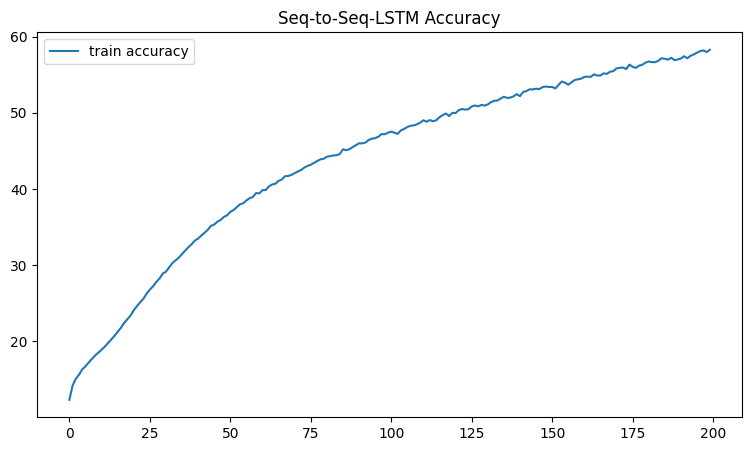

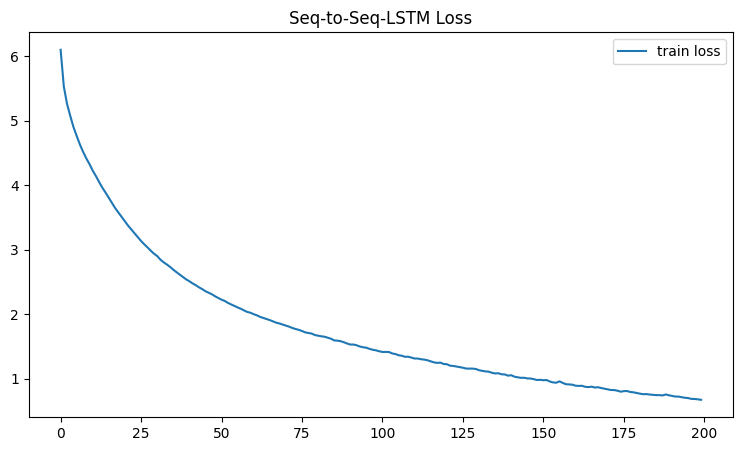

In [22]:
N_EPOCHS = 200
CLIP = 1
optimizer = optim.Adam(model.parameters(), lr=0.001)
results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
train_valid(train_loader, valid_loader, model, criterion,  N_EPOCHS, optimizer, results, CLIP, model_name='Seq-to-Seq-LSTM')

# Test One Poem from test dataset

In [23]:
random_index = random.randint(0, len(test_dataset))

print(f"Current Beyt: {train_dataset.data.loc[random_index,'Input']}")
print(f"Next: {train_dataset.data.loc[random_index,'Output']}")

Current Beyt: مرا دین کسری نباید همی / دلم سوی مادر گراید همی
Next: که دین مسیحاست آیین اوی / نگردم من از فره و دین اوی


In [24]:
sample = test_dataset[random_index]
def generate_poem(sample):
    
    input = sample['Input']
    output = sample['Output']
    model.eval()
    with torch.no_grad():
      src = input.to(device)
      src = torch.reshape(src, (len(src), 1))

      trg = output.to(device)
      trg = torch.reshape(trg, (len(trg), 1))

      pred = model(src, trg, 0) #turn off teacher forcing

      output_dim = pred.shape[-1]

      pred = pred[1:].view(-1, output_dim)
      trg = trg[1:].view(-1)

      pred_class = (pred.argmax(dim=1))

    predicted = []
    item = ['<EOS>', '<SOS>']

    for i in range(len(pred_class)):
        predicted.append(train_dataset.vocab.itos[pred_class[i].item()])
    res = [i for i in predicted if i not in item]

    print(' '.join(res))

## Our Network Response With LSTM

In [25]:
generate_poem(sample)

ازو بر تن خویشتن کامگار / دلت شاد گردد چو خرم بهار


## GRU

In [12]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

## Using Attention fore better result

it is usefulful to add an attention layer. This will take in the previous hidden state of the decoder, and all of the stacked forward and backward hidden states from the encoder.

Intuitively, this layer takes what we have decoded so far, and all of what we have encoded, to produce a vector, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode.

In [13]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)

In [14]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

In [15]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

In [16]:
TRG_PAD_IDX = train_dataset.PAD_IDX

INPUT_DIM = dictionary_size
OUTPUT_DIM = dictionary_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

gru_model = Seq2Seq(enc, dec, device).to(device)

optimizer = optim.Adam(gru_model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [17]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
gru_model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9191, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(9191, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=9191, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [18]:
print(f'The model has {sum(p.numel() for p in gru_model.parameters() if p.requires_grad):,} trainable parameters')

The model has 27,618,535 trainable parameters


Epoch 1
-------------------------------
Train Loss: 6.323 | Train Acc: 9.438%
Epoch 2
-------------------------------
Train Loss: 5.367 | Train Acc: 15.606%
Epoch 3
-------------------------------
Train Loss: 5.010 | Train Acc: 16.903%
Epoch 4
-------------------------------
Train Loss: 4.738 | Train Acc: 17.970%
Epoch 5
-------------------------------
Train Loss: 4.484 | Train Acc: 18.944%
Epoch 6
-------------------------------
Train Loss: 4.236 | Train Acc: 19.979%
Epoch 7
-------------------------------
Train Loss: 4.014 | Train Acc: 21.027%
Epoch 8
-------------------------------
Train Loss: 3.793 | Train Acc: 22.189%
Epoch 9
-------------------------------
Train Loss: 3.589 | Train Acc: 23.446%
Epoch 10
-------------------------------
Train Loss: 3.394 | Train Acc: 24.927%
Epoch 11
-------------------------------
Train Loss: 3.211 | Train Acc: 26.506%
Epoch 12
-------------------------------
Train Loss: 3.035 | Train Acc: 28.107%
Epoch 13
-------------------------------
Train Los

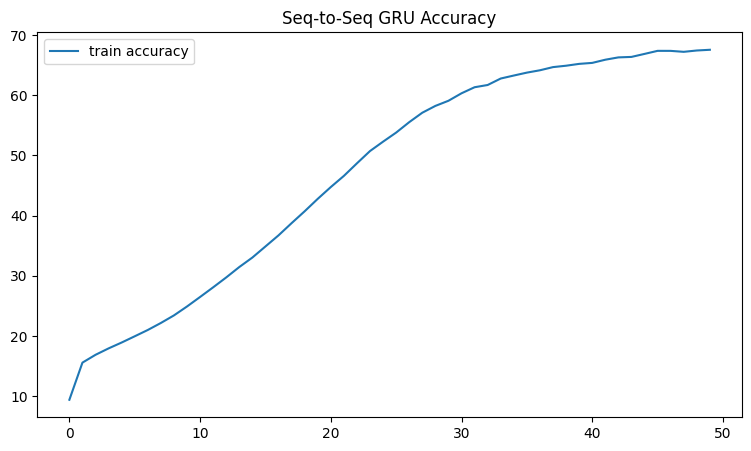

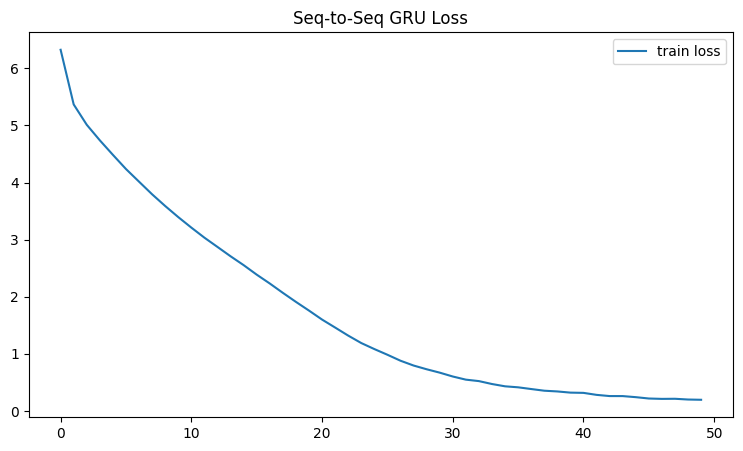

In [24]:
N_EPOCHS = 50
CLIP = 1
results = {'epoch':[], 'train loss':[], 'train accuracy':[], 'valid loss':[], 'valid accuracy':[]}
train_valid(train_loader, valid_loader, gru_model, criterion,  N_EPOCHS, optimizer, results, CLIP, model_name='Seq-to-Seq GRU')

# Test One Sample

In [35]:
random_index = random.randint(0, len(test_dataset))

print(f"Current Beyt: {test_dataset.data.loc[random_index,'Input']}")
print(f"Next: {test_dataset.data.loc[random_index,'Output']}")

Current Beyt: ترا خواسته گر ز بهر تنست / ببخش و بدان کین شب آبستنست
Next: اگر چند باشد شب دیریاز / برو تیرگی هم نماند دراز


In [36]:
sample = test_dataset[random_index]
def generate_poem(sample):
    
    input = sample['Input']
    output = sample['Output']
    gru_model.eval()
    with torch.no_grad():
      src = input.to(device)
      src = torch.reshape(src, (len(src), 1))

      trg = output.to(device)
      trg = torch.reshape(trg, (len(trg), 1))

      pred = gru_model(src, trg, 0) #turn off teacher forcing

      output_dim = pred.shape[-1]

      pred = pred[1:].view(-1, output_dim)
      trg = trg[1:].view(-1)

      pred_class = (pred.argmax(dim=1))

    predicted = []
    item = ['<EOS>', '<SOS>']

    for i in range(len(pred_class)):
        predicted.append(train_dataset.vocab.itos[pred_class[i].item()])
    res = [i for i in predicted if i not in item]

    print(' '.join(res))

## Our Prediction With GRU

In [37]:
generate_poem(sample)

برین گونه یک سال باشد سوار / نهان باشد از گردش روزگار


# Report

As you can see when we use GRU, we have better loss and accuracy and we get better results in less epochs.